# Optimal Weather Radar Network Design for Texas

**Date:** December 12, 2025

**Author:** Nikhil Trivedi

In [1]:
! pip install numpy pandas matplotlib gamspy geopandas rasterio pyproj -q

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gamspy as gp
import random
import geopandas as gpd
import requests
import rasterio
from pyproj import Transformer
import time
import os

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Set options
gp.set_options({'USE_PY_VAR_NAME': 'yes'})
pd.set_option('display.max_rows', 10)

## 1. Introduction

### 1.1 Problem Statement

Texas is prone to severe weather events, including tornadoes, hurricanes, supercells, flash floods, and even snowstorms. The weather warnings rely heavily on radar systems to detect these phenomena at low altitudes. However, the finite number of resources to build NEXRAD radars, along with terrain obstructions, often create "coverage gaps" where select regions lack high-quality radar data, making it difficult to detect low-level rotation and wind critical to monitoring tornadoes.

This project turns this meteorological issue into a Facility Location Problem (FLP). Our goal is to select the optimal locations for a limited number of new weather radars from a set of candidate airport sites. These radars are usually built at airports because they already contain much of the infrastructure needed to support NEXRAD radars, and also just have a direct need for high-quality radar data.

The objective is to maximize quality-weighted population coverage, ensuring that the maximum number of people are covered by high-resolution radar data. We will start by applying this problem to a relatively small synthetic dataset, and will then apply the same optimization model to real data to optimize radar placement in Texas.

As an Atmospheric & Oceanic Sciences student, I use my meteorological insight to accurately estimate radar quality based on several factors (to be described later). The exact criteria used, along with the functions used to define them, are admittedly somewhat subjective, but I defend my choices using meterological reasoning (see section 2).

### 1.2 Data Sources

To build a realistic model, we utilize three primary datasets:
1. **Population Centers:** Census Tract centroids from the 2020 US Census (via Texas Capitol Data Portal): https://data.capitol.texas.gov/dataset/2020-census-geography
2. **Candidate Sites:** Public airports from TxDOT/FAA records, filtered to ensure infrastructure viability: https://gis-txdot.opendata.arcgis.com/datasets/texas-airports
3. **Terrain Data:** Digital Elevation Models (DEM) from the USGS National Map (1km resolution) to calculate beam blockage and ground elevation.

In [3]:
# Parameters for the grid
KM_PER_GRID_UNIT = 50  # Grid scale
GRID_SIZE = 10  # 10x10 grid (represents 500km x 500km area)
NUM_POPULATION_POINTS = 60  # Number of census tract centers
NUM_AIRPORTS = 25  # Number of airports (candidate sites)
NUM_RADARS = 5 # Number of radars to place
MAX_RANGE = 4.0  # Maximum radar range (200 km)

# Generate simple terrain elevation map
x_terrain = np.linspace(0, GRID_SIZE, 60)
y_terrain = np.linspace(0, GRID_SIZE, 60)
X, Y = np.meshgrid(x_terrain, y_terrain)

# Create simple terrain: base elevation (200m)
terrain = np.ones_like(X) * 200

# Mountains: centered at (2.5, 7.5), H=1200m, and (7.5, 2.5), H=1000m
mountain1 = 1200 * np.exp(-((X-2.5)**2 + (Y-7.5)**2) / 2)
mountain2 = 1000 * np.exp(-((X-7.5)**2 + (Y-2.5)**2) / 2)

# Valleys: centered at (7.5, 7.5), D=-100m, and (2.5, 2.5), D=-150m
valley1 = -100 * np.exp(-((X-7.5)**2 + (Y-7.5)**2) / 3)
valley2 = -150 * np.exp(-((X-2.5)**2 + (Y-2.5)**2) / 3)

# Combine all features
terrain = terrain + mountain1 + mountain2 + valley1 + valley2

# Get elevation at a given point using the nearest terrain map grid point
def get_elevation(x, y):
    if x < 0 or x > GRID_SIZE or y < 0 or y > GRID_SIZE:
        return 0
    x_idx = np.clip(int(x * (len(x_terrain)-1) / GRID_SIZE), 0, len(x_terrain)-2)
    y_idx = np.clip(int(y * (len(y_terrain)-1) / GRID_SIZE), 0, len(y_terrain)-2)
    return terrain[y_idx, x_idx]

# Generate population centers (census tracts)
pop_points = []
for i in range(NUM_POPULATION_POINTS):
    for attempt in range(10):
        x = np.random.uniform(0, GRID_SIZE)
        y = np.random.uniform(0, GRID_SIZE)
        elevation = get_elevation(x, y)

        # Define population range, no population on mountains
        if elevation < 600:
            break
    population = np.random.randint(10000, 80000)

    pop_points.append({'id': f'pop_{i}', 'x': x, 'y': y,
                       'population': population, 'elevation': elevation})

pop_df = pd.DataFrame(pop_points)
total_population = pop_df['population'].sum()
print(f"Population DataFrame:\n{pop_df}")
print(f"Total Population: {total_population:,}\n")

# Generate airport locations (in flat areas to be realistic)
airports_list = []
for i in range(NUM_AIRPORTS):
    for attempt in range(10):
        x = np.random.uniform(0, GRID_SIZE)
        y = np.random.uniform(0, GRID_SIZE)
        elevation = get_elevation(x, y)

        # Accept if relatively flat (elevation < 400m)
        if elevation < 400:
            airports_list.append({'id': f'airport_{i}', 'x': x, 'y': y, 'elevation': elevation})
            break

airports_df = pd.DataFrame(airports_list)
print(f"Airport DataFrame:\n{airports_df}")

Population DataFrame:
        id         x         y  population   elevation
0    pop_0  3.745401  9.507143       64886  277.400649
1    pop_1  4.458328  0.999749       54131  184.170096
2    pop_2  1.428668  6.508885       74820  555.316411
3    pop_3  9.699099  8.324426       77969  183.012949
4    pop_4  1.818250  1.834045       63707  102.629151
..     ...       ...       ...         ...         ...
55  pop_55  1.375209  3.410664       49384  125.663164
56  pop_56  2.090716  5.414480       70713  275.333346
57  pop_57  8.172222  5.552008       12049  190.606977
58  pop_58  9.962537  9.654194       30932  195.639054
59  pop_59  9.004181  6.331015       53016  171.231112

[60 rows x 5 columns]
Total Population: 2,761,524

Airport DataFrame:
            id         x         y   elevation
0    airport_0  8.466611  8.563243  141.295528
1    airport_1  4.045081  8.877701  389.769301
2    airport_2  8.509284  9.356350  175.905879
3    airport_3  7.853407  6.689883  125.623048
4    airport

## 2. Methodology and Physics

### 2.1 The "Coverage Quality" Metric

Unlike standard facility location problems that treat coverage as binary (Covered/Not Covered), radar coverage for meteorlogical purposes is heavily dependent on coverage quality, and thus requires a continuous quality metric. A radar signal primarily degrades based on three physical factors:

1. **Distance (Beam Broadening):** As the radar beam travels, it widens. At long ranges, the beam width becomes too large to accurately resolve small-scale features like tornado vortices. Radar beam width increases linearly with distance, so we model this using a piecewise linear decay function. Within 50 km, beam width is considered "perfect" and is not penalized, but beyond 50 km, we start linearly penalizing this beam width.

2. **Beam Height (Earth Curvature):** To detect surface-based hazards, the radar beam must remain close to the ground. Due to the beam angle (which we will assume to be the standard 0.5° tilt) and curvature of the Earth, the beam rises with distance. We again use a piecewise linear function to penalize coverage, this time penalizing once the beam height exceeds 1000m AGL, as it may overshoot low-level storm features. We choose 1000m in particular because this is a good approximation for the depth of the planetary boundary layer, which contains important information for surface weather.

3. **Terrain Blockage:** We perform a line-of-sight analysis using terrain elevation data. If a mountain intersects the radar beam path (again calculated at a 0.5° tilt), the coverage quality is set to zero.

## 2.2 Beam Propagation Model

To accurately calculate beam height, we employ a simplified beam geometry model that accounts for Earth's curvature and atmospheric refraction. The radar beam is assumed to travel at a constant 0.5° elevation angle.

The beam height at any distance $d$ (in meters) is calculated as:
$$H_{beam}(d) = H_{radar} + \sqrt{d^2 + k R_e^2} - k R_e + d \cdot \tan(0.5°)$$

Where:
- $H_{beam}$ is the beam height above mean sea level at distance $d$
- $H_{radar}$ is the radar antenna elevation (meters above sea level)
- $d$ is the horizontal distance from the radar (in meters)
- $R_e = 6,371,000$ m is Earth's radius
- $k = 4/3$ is the effective Earth radius factor accounting for standard atmospheric refraction

The first term accounts for the radar elevation, the second term accounts for the Earth's curvature with refraction, and the third term accounts for the beam's upward angle.

The height above ground level (AGL) at any point is then:

$$H_{AGL} = H_{beam}(d) - H_{terrain}$$

This model provides a realistic estimate of beam height, ensuring we can identify areas where the beam rises too high above the ground to detect low-level weather phenomena, and where terrain blocks the beam.

In [4]:
import numpy as np

def euclidean_distance(x1, y1, x2, y2):
    """Calculate Euclidean distance between two points"""
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def compute_beam_height(distance_km, radar_elev_m, beam_angle_deg=0.5):
    """
    Calculates the height of the radar beam (in meters) at a specific distance,
    accounting for Earth's curvature and standard atmospheric refraction
    """
    Re = 6371000 # Earth radius (m)
    kRe = (4/3) * Re # Effective radius factor (standard refraction)

    d_m = distance_km * 1000
    beam_angle_rad = np.deg2rad(beam_angle_deg)

    # Height contribution from Earth's curvature + refraction
    curvature_term = np.sqrt(d_m**2 + kRe**2) - kRe

    # Height contribution from beam elevation angle
    beam_rise = d_m * np.tan(beam_angle_rad)

    return radar_elev_m + curvature_term + beam_rise

def check_terrain_blockage(x1, y1, elev1, x2, y2, elev2, get_elev_func, km_per_unit):
    """
    Check if terrain blocks line of sight between two points using 0.5 degree beam angle.
    Returns blockage factor (0 = fully blocked, 1 = no blockage)
    """
    num_samples = 25

    for i in range(1, num_samples):
        # Linear interpolation between points
        t = i / num_samples
        x = x1 + t * (x2 - x1)
        y = y1 + t * (y2 - y1)

        terrain_elev = get_elev_func(x, y)
        dist_so_far_units = euclidean_distance(x1, y1, x, y)
        dist_so_far_km = dist_so_far_units * km_per_unit

        # If terrain is higher than beam at any point, it is blocked
        beam_height = compute_beam_height(dist_so_far_km, elev1)
        if terrain_elev > beam_height:
            return 0
    return 1

def calculate_coverage_quality(airport_x, airport_y, airport_elev, pop_x, pop_y,
                               pop_elev, distance, max_range, get_elev_func, km_per_unit):
    """
    Calculate coverage quality based on distance, low-level coverage, and terrain blockage.
    Returns resulting quality (a score between 0 and 1)
    """
    if distance > max_range:
        return 0.0

    dist_km = distance * km_per_unit
    max_range_km = max_range * km_per_unit

    # Distance Penalty: Piecewise function
    # No penalty <50 km, then drops linearly to a penalty of 70% at max range
    distance_factor = max(0.4, 1.0 - 0.3 * (dist_km - 50) / (max_range_km - 50)) if dist_km > 50 else 1.0

    # Beam Height Penalty: Calculate beam height at target
    beam_height_at_target = compute_beam_height(dist_km, airport_elev)
    hgt_abv_target = beam_height_at_target - pop_elev

    # Piecewise penalty (no penalty <1000m, 10% for every 100m above that, max penalty of 70%)
    beam_penalty = max(0.3, 1.0 - (hgt_abv_target - 1000) / 1000) if hgt_abv_target > 1000 else 1.0

    # Terrain Blockage Penalty: Check if mountains block beam path
    blockage_factor = check_terrain_blockage(airport_x, airport_y, airport_elev, pop_x, pop_y,
                                             pop_elev, get_elev_func, km_per_unit)

    # Combine all factors into a single score between 0 and 1
    quality = distance_factor * beam_penalty * blockage_factor
    return max(0.0, min(1.0, quality))

## 2.3 Coverage Quality Matrix Construction

With our physics models defined, we now construct a coverage quality matrix that encodes all valid radar-population relationships. This matrix will serve as the input to our optimization model.

For each airport-population center pair:
1. Calculate Euclidean distance
2. Apply our coverage quality function (incorporating distance decay, beam height penalty, and terrain blockage)
3. Store only meaningful connections (quality > 0.01) to keep the model sparse and computationally efficient

This sparse representation dramatically reduces the problem size from 25 × 60 = 1,500 potential links to only those that are physically viable (where distance is within the maximum radar range and the beam isn't blocked). This becomes very important for the much larger model run on real Texas data.

In [5]:
# Create and populate coverage quality matrix
coverage_data = []
for _, airport in airports_df.iterrows():
    for _, pop in pop_df.iterrows():
        dist = euclidean_distance(airport['x'], airport['y'], pop['x'], pop['y'])

        quality = calculate_coverage_quality(
            airport['x'], airport['y'], airport['elevation'],
            pop['x'], pop['y'], pop['elevation'], dist,
            MAX_RANGE, get_elevation, KM_PER_GRID_UNIT
        )

        if quality > 0.01:  # Only include meaningful coverage
            coverage_data.append({'airport': airport['id'],'pop_point': pop['id'],
                                  'quality': quality, 'distance': dist})

coverage_df = pd.DataFrame(coverage_data)
print(f"Coverage Quality Matrix:\n{coverage_df.head()}")
print(f"Total Coverage Connections: {len(coverage_df)}\n")

Coverage Quality Matrix:
     airport pop_point   quality  distance
0  airport_0     pop_3  0.974459  1.255411
1  airport_0     pop_9  0.216025  3.799155
2  airport_0    pop_11  0.237535  3.082177
3  airport_0    pop_18  0.984884  1.151163
4  airport_0    pop_23  0.253003  2.566572
Total Coverage Connections: 472



## 3. Optimization Model Formulation

We formulate this problem as a variant of a Location-Allocation Problem. Instead of simply summing coverage scores (which would allow "stacking" poor signals to create a good score), we use an assignment variable to ensure each population center is served by exactly one "primary" radar (specifically, the one offering the highest quality signal).

### 3.1 Sets

- $J$: Set of candidate airport locations (Radars)
- $I$: Set of population centers (Census Tracts)
- $L \subseteq J \times I$: Set of valid links where tract $i$ is within range of airport $j$

### 3.2 Parameters

- $P_i$: Population of census tract $i$
- $Q_{ji}$: Coverage quality score $(0 \le Q \le 1)$ provided by radar $j$ to tract $i$ (calculated via physics logic)
- $K$: The number of radars to build

### 3.3 Decision Variables

- $x_j \in \{0, 1\}$: Binary variable. Equal to 1 if a radar is built at airport $j$, 0 otherwise
- $z_{ji} \in \{0, 1\}$: Binary assignment variable. Equal to 1 if population center $i$ is assigned to radar $j$ as its primary coverage source, 0 otherwise

Note: The assignment variable $z_{ji}$ ensures each population center receives coverage from only its single best radar source, preventing artificial "stacking" of poor quality signals.

### 3.4 Mathematical Formulation

**Objective:** Maximize the total quality-weighted population coverage.

$$\text{Maximize } Z = \sum_{(j,i) \in L} P_i \cdot Q_{ji} \cdot z_{ji}$$

**Subject to:**

1. **Budget Constraint:** Build exactly $K$ radars: $\sum_{j \in J} x_j = K$


2. **Single Source Assignment:** Each census tract can be assigned to at most one radar: $\sum_{j \in J : (j,i) \in L} z_{ji} \le 1 \quad \forall i \in I$

3. **Linkage Constraint:** A tract can only be assigned to an airport if a radar is built there: $z_{ji} \le x_j \quad \forall (j,i) \in L$


## 3.5 Model Implementation in GAMSPy

We will now implement this mathematical model using GAMSPy, a Python interface to GAMS optimization solvers. We will first define our sets, parameters, and binary decision variables. We will then carefully implement our three constraints and define our objective function, finally we will solve using the CPLEX MIP solver.

The sparse formulation (using valid_links) ensures we only create variables for feasible airport-population pairs, dramatically improving computational efficiency.

In [6]:
# Initialize container
m = gp.Container()

# Define sets
airports = gp.Set(m, records=airports_df['id'], description="Airport locations (radar candidates)")
pop_points = gp.Set(m, records=pop_df['id'], description="Population centers (census tracts)")

# Define dynamic set for valid coverage links only
valid_links = gp.Set(m, domain=[airports, pop_points], records=coverage_df[['airport', 'pop_point']],
                     description="Valid airport-population coverage pairs")

# Define parameters
population = gp.Parameter(m, domain=pop_points, records=pop_df[['id', 'population']],
                         description="Population at each census tract")

coverage_quality = gp.Parameter(m, domain=[airports, pop_points],
                                records=coverage_df[['airport', 'pop_point', 'quality']],
                                description="Terrain-adjusted coverage quality")

num_radars = gp.Parameter(m, records=NUM_RADARS, description="Number of radars to build")

# Define decision variables
x = gp.Variable(m, domain=airports, type="binary",
                description="1 if radar is built at airport, 0 otherwise")

z = gp.Variable(m, domain=[airports, pop_points], type="binary",
                description="1 if airport provides primary coverage to population point")

total_quality_weighted = gp.Variable(m, description="Total quality-weighted population coverage")

# Constraint 1: Build exactly num_radars radars
radar_limit = gp.Equation(m)
radar_limit[:] = gp.Sum(airports, x[airports]) == num_radars

# Constraint 2: Each population point can be assigned to at most one radar
# This prevents double-counting and ensures we pick the highest quality source
single_source = gp.Equation(m, domain=pop_points)
single_source[pop_points] = gp.Sum(valid_links[airports, pop_points], z[airports, pop_points]) <= 1

# Constraint 3: Can only assign coverage if radar is actually built (links x and z)
linkage = gp.Equation(m, domain=[airports, pop_points])
linkage[airports, pop_points].where[valid_links[airports, pop_points]] = z[airports, pop_points] <= x[airports]

# Objective: Sum (population[p] * quality[a,p] * z[a,p]) over all valid assignments
obj_eq = gp.Equation(m, description="Maximize quality-weighted population coverage")
obj_eq[:] = total_quality_weighted == gp.Sum(
    valid_links[airports, pop_points],
    population[pop_points] * coverage_quality[airports, pop_points] * z[airports, pop_points]
)

# Fix z to 0 for all invalid links
z.fx[airports, pop_points].where[~valid_links[airports, pop_points]] = 0

# Create and solve model
radar_model = gp.Model(
    m,
    equations=[obj_eq, radar_limit, single_source, linkage],
    problem="MIP",
    sense=gp.Sense.MAX,
    objective=total_quality_weighted
)
display(radar_model.solve(solver="cplex"))

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,2.037662e+06,534,498,MIP,CPLEX,0.01


## 4. Data Processing and Visualization

### 4.1 Data Processing and Visualization Function Descriptions

The `display_results()` function extracts and processes the optimization solution to provide:
- Individual radar performance metrics (tracts covered, population served)
- Network-wide coverage statistics
- Quality-tiered population coverage (>75%, >50%, any coverage)

The `visualize_results()` function creates a two-panel visualization:
- **Left panel**: Problem setup showing all census tracts and candidate sites overlaid on terrain
- **Right panel**: Optimal solution with selected radar sites, coverage circles, and census tracts colored by quality

In [7]:
def display_results(x, z, coverage_df, pop_df, total_population):
    """
    Display use optimization results related to radar performance, both for individual
    radars and across the network.
    """
    # Extract all chosen airports and airport-population assignments
    x_records = x.records[x.records['level'] > 0.5]
    z_records = z.records[z.records['level'] > 0.5].copy()

    # Get the actual column names (they vary based on set names)
    airport_col = [col for col in x_records.columns if col != 'level'][0]
    z_cols = [col for col in z_records.columns if col != 'level']
    z_airport_col, z_pop_col = z_cols[0], z_cols[1]

    selected_radars = x_records[airport_col].tolist()

    # Add population and quality data to each assignment
    pop_lookup = pop_df.set_index('id')['population']
    z_records['population'] = z_records[z_pop_col].map(pop_lookup).astype(int)
    z_records = z_records.merge(coverage_df[['airport', 'pop_point', 'quality']],
                                 left_on=[z_airport_col, z_pop_col],
                                 right_on=['airport', 'pop_point'], how='left')

    # Aggregate census tracts and total population covered by each airport
    radar_stats = z_records.groupby(z_airport_col, observed=True).agg(
        Tracts_Covered=(z_pop_col, 'count'),
        Population_Served=('population', 'sum')
    ).sort_values('Population_Served', ascending=False)
    radar_stats['Pct_of_Total_Pop'] = (radar_stats['Population_Served'] / total_population) * 100

    print(f"Individual Radar Performance:\n{radar_stats}")
    print("\nNetwork-Wide Radar Performance:")
    print(f"Census Tracts Covered: {len(z_records)} / {len(pop_df)}")

    # Calculate quality-weighted coverage: sum(population * quality)
    weighted_pop = (z_records['population'] * z_records['quality']).sum()
    weighted_pct = (weighted_pop / total_population) * 100
    print(f"Quality-Weighted Coverage: {weighted_pct:.2f}%\n")

    # Break down population covered by quality tiers
    print("Population Coverage by Quality:")
    for threshold, label in [(0.75, ">75%"), (0.5, ">50%"), (0, "Any")]:
        pop = z_records[z_records['quality'] > threshold]['population'].sum()
        print(f"{label} Quality: {pop/total_population*100:5.1f}% ({pop:,} people)")

    # Return results that will be used in visualization
    return {
        'selected_radars': selected_radars,
        'assignments': z_records.rename(columns={z_pop_col: 'pop_points'}),
        'weighted_pct': weighted_pct
    }

def visualize_results(pop_df, airports_df, results, terrain, extent, max_range,
                      title_prefix="", km_per_unit=50, boundary=None):
    """Create visualization of radar placement results"""

    # Merge census tract locations with quality scores
    assignments = results['assignments']
    plot_data = pop_df.merge(assignments[['pop_points', 'quality']],
                             left_on='id', right_on='pop_points', how='left')
    plot_data['quality'] = plot_data['quality'].fillna(0)

    selected_sites = airports_df[airports_df['id'].isin(results['selected_radars'])]

    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), constrained_layout=True)
    kw = {'edgecolors': 'black', 'linewidth': 0.8, 'alpha': 0.7}

    # Add state border if provided
    if boundary is not None:
        boundary.boundary.plot(ax=ax1, color='black', linewidth=2)
        boundary.boundary.plot(ax=ax2, color='black', linewidth=2)

    # Subplot 1: Terrain map, census tracts, and candidate aiports
    im1 = ax1.imshow(terrain, extent=extent, origin='lower', cmap='terrain', alpha=0.5, aspect='auto')
    plt.colorbar(im1, ax=ax1, label='Elevation (m)', pad=0.02)

    # Census tracts colored by size, candidate airports (triangles)
    ax1.scatter(pop_df['x'], pop_df['y'], s=pop_df['population']/200, c='red', label='Census Tract', **kw)
    ax1.scatter(airports_df['x'], airports_df['y'], c='blue', marker='^', s=100, label='Candidate', **kw)
    ax1.set_title(f'{len(pop_df)} Census Tracts & {len(airports_df)} Candidate Sites', fontweight='bold')
    ax1.legend(loc='lower right')

    # Subplot 2: Terrain map (grayscale)
    ax2.imshow(terrain, extent=extent, origin='lower', cmap='gray', alpha=0.4, aspect='auto')

    # Census tracts colored by quality, selected airports (stars), radar ranges (dashed circles)
    sc = ax2.scatter(plot_data['x'], plot_data['y'], s=plot_data['population']/200,
                     c=plot_data['quality'], cmap='RdYlGn', vmin=0, vmax=1, **kw)
    plt.colorbar(sc, ax=ax2, label='Coverage Quality (0-1)', pad=0.02)

    ax2.scatter(selected_sites['x'], selected_sites['y'], c='red', marker='*', s=500,
                label='Selected Radar Site', edgecolors='black', zorder=5)

    for _, row in selected_sites.iterrows():
        ax2.add_patch(plt.Circle((row['x'], row['y']), max_range, color='red', fill=False, linestyle='--', alpha=0.5))

    ax2.set_title(f'{title_prefix}Optimal Radar Placement ({results["weighted_pct"]:.1f}% Quality-Weighted Coverage)', fontweight='bold')
    ax2.legend(loc='lower right')

    # Format both axes
    xlabel = 'X (50km grid units)' if km_per_unit == 50 else 'X (km)'
    ylabel = 'Y (50km grid units)' if km_per_unit == 50 else 'Y (km)'

    for ax in [ax1, ax2]:
        ax.set_xlim(extent[0] - 0.5, extent[1] + 0.5)
        ax.set_ylim(extent[2] - 0.5, extent[3] + 0.5)
        ax.set_xlabel(xlabel, fontsize=10)
        ax.set_ylabel(ylabel, fontsize=10)
        ax.grid(True, alpha=0.4)

    return fig

Individual Radar Performance:
            Tracts_Covered  Population_Served  Pct_of_Total_Pop
airports                                                       
airport_6               19             731572         26.491604
airport_17              10             552568         20.009531
airport_1               10             549365         19.893544
airport_21              12             513387         18.590713
airport_18               6             291116         10.541860

Network-Wide Radar Performance:
Census Tracts Covered: 57 / 60
Quality-Weighted Coverage: 73.79%

Population Coverage by Quality:
>75% Quality:  66.1% (1,826,522 people)
>50% Quality:  69.2% (1,912,185 people)
Any Quality:  95.5% (2,638,008 people)


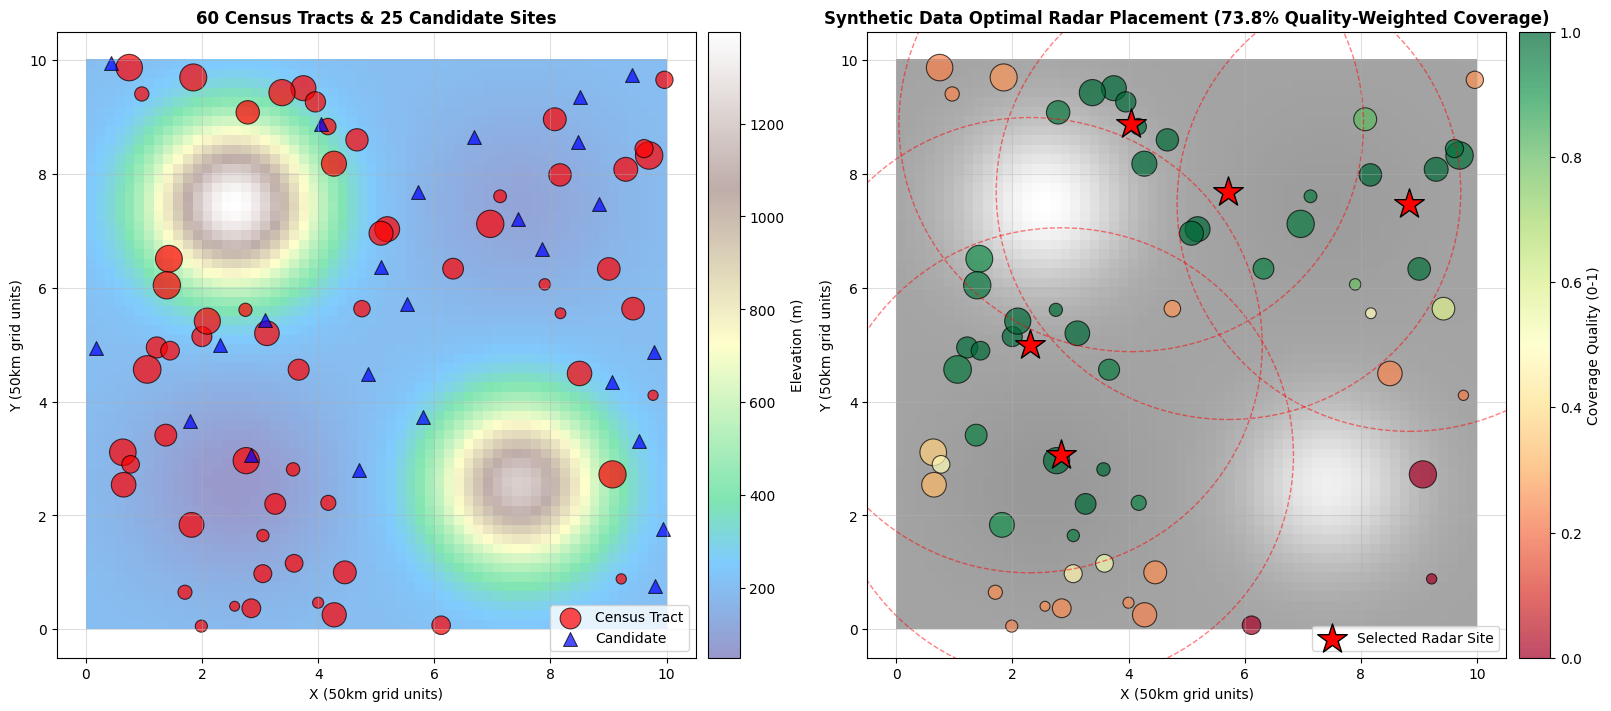

In [8]:
# Print relevant statistics on results
results_synthetic = display_results(x, z, coverage_df, pop_df, total_population)

# Visualize results
fig = visualize_results(pop_df, airports_df, results_synthetic, terrain,
                       extent=[0, GRID_SIZE, 0, GRID_SIZE],
                       max_range=MAX_RANGE, title_prefix="Synthetic Data ",
                       km_per_unit=KM_PER_GRID_UNIT)

plt.savefig('radar_location_allocation_synthetic.png', dpi=150, bbox_inches='tight')
plt.show()

### 4.2 Brief Solution Analysis

Based on our arbitrarily defined data (500km x 500km area, 60 census tracts, 25 airport candidate sites, 5 radars), we have most census tracts covered and a quality-weighted coverage (which is the value we are trying to optimize) of 73.79%. We can see that this is not evenly distributed; nearly all of the population (95.5%) has some radar coverage, but only 69.2% has coverage with >50% quality.

Taking a look at our visualization, we see our terrain, census tracts, and airport candidate sites on our left subplot. On our right subplot, we see the optimal solution; our 5 radars are spread across the map (on our chosen candidate sites) in such a way that they maximize the quality-weighted coverage. Note that not every census tract has perfect coverage, and a few even have no coverage at all. This highlights the resource limitations of this problem, and helps display why turning it into an optimization problem is so important (this will become even more clear on the Texas data).  

## 5. Modeling the Optimal Radar Placement in Texas
### 5.1 Real-World Data: Texas Weather Radar Network

Having validated our model on synthetic data, we now apply it to real Texas data. This involves three key datasets:

1. **Census Tracts**: 6,896 census tract centroids from the 2020 US Census, representing population centers across Texas
2. **Candidate Airports**: 127 regional/international airports (3-letter FAA codes) filtered from 366 total airports to ensure infrastructure viability
3. **Terrain Elevation**: USGS National Map digital elevation model (DEM) at ~1km resolution

We'll use the same coordinate reference system (EPSG:3081 - Texas Centric Mapping System/Lambert Conformal Conic) and convert to kilometers for consistency with our model.

In [9]:
# Read in and inspect actual raw data for Texas

# Read in census tracts with GeoPandas
tracts_raw = gpd.read_file("tracts/Tracts.shp")
print(f"Number of Census Tracts: {tracts_raw.shape[0]} tracts\nCRS: {tracts_raw.crs}")

# Read in population data with Pandas
pop_data = pd.read_csv("tracts/tracts_pop.txt")
print(f"\nPopulation Data Columns: {pop_data.columns.tolist()}")

# Read in airports with GeoPandas
airports_raw = gpd.read_file("Texas_Airports/Airport.shp")
print(f"\nAirports: {airports_raw.shape[0]} airports\nCRS: {airports_raw.crs}")

# Filter to only include regional/international airports
airports_filtered = airports_raw[airports_raw['FAA_CD'].str.match(r'^[A-Z]{3}$')].copy()
print(f"Filtered down to {len(airports_filtered)} major airports")

Number of Census Tracts: 6896 tracts
CRS: PROJCS["NAD_1983_Lambert_Conformal_Conic",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",31.1666666666667],PARAMETER["central_meridian",-100],PARAMETER["standard_parallel_1",27.4166666666667],PARAMETER["standard_parallel_2",34.9166666666667],PARAMETER["false_easting",1000000],PARAMETER["false_northing",1000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]

Population Data Columns: ['FID', 'STATE', 'FIPS', 'TRT', 'TRTKEY', 'CTTRTKEY', 'FENAME', 'COLOR', 'anglo', 'asian', 'hisp', 'total', 'vap', 'black', 'bh', 'nanglo', 'anglovap', 'hispvap', 'bhvap', 'blackvap', 'asianvap', 'nanglovap', 'Shape_Leng', 'Shape_Ar_1']

Airports: 366 airports
CRS: EPSG:3857
Filtered down to 127 major airp

### 5.2 Data Preprocessing

We need to prepare the data in the same format as our synthetic example so that we can apply the same optimization model to it. We need to:
1. Merge census tract centroids with population data
2. Transform all coordinates to Texas-centric projection (EPSG:3081) in kilometers
3. Extract centroid coordinates for each census tract
4. Filter out unpopulated tracts (for efficiency purposes)

In [10]:
# Process census tracts data

# Fix key types and merge population data
tracts_raw['CTTRTKEY'] = tracts_raw['CTTRTKEY'].astype(int)
pop_data['CTTRTKEY'] = pop_data['CTTRTKEY'].astype(int)
tracts_raw = tracts_raw.merge(pop_data[['CTTRTKEY', 'total']], on='CTTRTKEY', how='inner')

# Reproject data to Texas meters and create population DataFrame
tracts_raw = tracts_raw.to_crs(epsg=3081)
pop_df_tx = pd.DataFrame({'id': tracts_raw['CTTRTKEY'],
                          'x': tracts_raw.centroid.x / 1000, 'y': tracts_raw.centroid.y / 1000,
                          'population': tracts_raw['total']})

# Filter out zero-population tracts
pop_df_tx = pop_df_tx[pop_df_tx['population'] > 0].copy()

print(f"{len(pop_df_tx)} census tracts with total population: {pop_df_tx['population'].sum():,.0f}")
print(pop_df_tx)

6868 census tracts with total population: 29,145,505
             id            x            y  population
0       1950100  1419.316509  1097.481851        4641
1       1950401  1395.157267  1070.635298        5782
2       1950402  1385.936171  1076.930995        7115
3       1950500  1411.766621  1076.860458        4479
4       1950600  1409.355540  1072.643931        6036
...         ...          ...          ...         ...
6891  505950402  1082.869890   539.612977        2567
6892  507950100  1037.534323   755.449675         855
6893  507950200  1005.691916   759.520887        1483
6894  507950301  1020.099628   733.904548        1744
6895  507950302  1017.365392   723.291246        5588

[6868 rows x 4 columns]


### 5.3 Terrain Elevation Data Acquisition

Finally, we need to get elevation data for the entire state so we can add it to our DataFrames and use it for our physics calculations. We will do this by downloading a Digital Elevation Model (DEM) from the USGS National Elevation Dataset (3DEP) covering bounding box that incorporates all of Texas.

The data is requested at roughly 1km resolution, which provides sufficient detail for radar line-of-sight calculations while remaining computationally manageable.

In [11]:
# Download statewide elevation data(or read it in if it already exists)

dem_file = "Texas_DEM.tif"

if os.path.exists(dem_file):
    print(f"{dem_file} exists - skipping download")
else:
    print("Downloading Texas DEM from USGS...")
    url = "https://elevation.nationalmap.gov/arcgis/rest/services/3DEPElevation/ImageServer/exportImage"
    params = {
        'bbox': '-106.6,25.8,-93.5,36.5', # Texas bounds
        'bboxSR': '4326', # Lat/Lon coords
        'size': '1500,1200', # ~1km resolution
        'imageSR': '4326',
        'format': 'tiff',
        'pixelType': 'F32',
        'f': 'image'
    }

    # Attempt to get data from USGS elevation API
    try:
        response = requests.get(url, params=params, stream=True, timeout=30)
        if response.status_code == 200:
            with open(dem_file, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print(f"Downloaded {dem_file}")
        else:
            print(f"Download failed: Status {response.status_code}")
    except Exception as e:
        print(f"Download error: {e}")

Texas_DEM.tif exists - skipping download


### 5.4 Elevation Sampling

With the DEM downloaded, we get elevation values for all airports and census tract centroids. This involves:
1. Transforming coordinates from Texas projection (EPSG:3081) to lat/lon (EPSG:4326)
2. Using the rasterio library to query the DEM at each location
3. Handling invalid/ocean values (< -1000m) by setting them to 0

These elevation values are critical for both calculating beam height above ground and detecting terrain blockage.

In [12]:
# Add elevations to both airports and census tracts from DEM

src = rasterio.open(dem_file)
terrain_texas = src.read(1)
transformer = Transformer.from_crs("EPSG:3081", "EPSG:4326", always_xy=True)

def sample_elevations(x_coords, y_coords, in_km=False):
    """Sample elevation values from DEM for given coordinates"""
    elevations = []
    for x, y in zip(x_coords, y_coords):
        x_m, y_m = (x * 1000, y * 1000) if in_km else (x, y)
        lon, lat = transformer.transform(x_m, y_m)
        try:
            row, col = src.index(lon, lat)
            val = terrain_texas[row, col]
            elevations.append(0 if val < -1000 else val)
        except:
            elevations.append(0)
    return elevations

airports_3081 = airports_filtered.to_crs(epsg=3081)

airport_elevations = sample_elevations(airports_3081.geometry.x, airports_3081.geometry.y)
census_elevations = sample_elevations(pop_df_tx.x, pop_df_tx.y, in_km=True)

airports_df_tx = pd.DataFrame({
    'id': airports_filtered['FAA_CD'].astype(str),
    'x': airports_3081.geometry.x / 1000,
    'y': airports_3081.geometry.y / 1000,
    'elevation': airport_elevations
})

pop_df_tx['elevation'] = census_elevations
pop_df_tx['id'] = pop_df_tx['id'].astype(str)

print(f"Added airport elevations (mean: {airports_df_tx['elevation'].mean():.1f}m)")
print(f"Added census elevations (mean: {pop_df_tx['elevation'].mean():.1f}m)")
print(f"\nAirport DataFrame:\n{airports_df_tx}")
print(f"\nCensus Tract DataFrame:\n{pop_df_tx}")

Added airport elevations (mean: 324.5m)
Added census elevations (mean: 217.7m)

Airport DataFrame:
      id            x            y    elevation
1    AMA   844.634352  1450.088165  1099.088501
2    PPA   909.657571  1492.995503   987.904480
3    BGD   873.709109  1503.051951   913.562744
4    DHT   770.074697  1540.736604  1215.001587
5    DUX   817.952339  1521.450829  1128.312988
..   ...          ...          ...          ...
353  PVW   841.785495  1333.528567  1026.802734
356  CDS   973.536684  1361.774962   593.197876
361  HRX   787.216104  1410.989573  1152.866211
363  GRK  1206.853295   991.639752   314.515533
364  BYY  1402.752291   764.813716    12.456262

[127 rows x 4 columns]

Census Tract DataFrame:
             id            x            y  population   elevation
0       1950100  1419.316509  1097.481851        4641  142.477020
1       1950401  1395.157267  1070.635298        5782   77.424179
2       1950402  1385.936171  1076.930995        7115   74.477547
3       1950

### 5.5 Coverage Quality Matrix for Texas

We now compute the coverage quality matrix for the real Texas data. Although this ran quickly for our synthetic data, this is computationally intensive for the Texas data due to the much larger scale (127 candidate airports × 6,868 census tracts = 872,236 potential pairs)

For each pair within range (230km), we must:
- Calculate distance
- Sample 25 terrain points along the path to check for blockage
- Apply distance, beam height, and blockage penalties

**Computational Note**: This calculation takes several minutes. We cache the result in `coverage_quality_texas.csv` to avoid recomputation, but note that we can simply delete the file and re-run this cell if we want to force recomputation.

The parameters for the Texas data are more carefully chosen to accurately reflect the real world:
- **MAX_RANGE_TEXAS = 230 km**: Maximum range for Doppler velocity data on NEXRAD radars (a critical field for monitoring wind)
- **NUM_RADARS_TEXAS = 13**: Current number of NEXRAD radars in Texas

In [13]:
MAX_RANGE_TEXAS = 230
NUM_RADARS_TEXAS = 13
KM_PER_GRID_UNIT_TEXAS = 1
total_population_texas = pop_df_tx['population'].sum()

coverage_file_texas = "coverage_quality_texas.csv"

# Check if the file already exists and read it in if it does
if os.path.exists(coverage_file_texas):
    print(f"Loading cached coverage matrix from {coverage_file_texas}")
    coverage_df_texas = pd.read_csv(coverage_file_texas)
    coverage_df_texas['airport'] = coverage_df_texas['airport'].astype(str)
    coverage_df_texas['pop_point'] = coverage_df_texas['pop_point'].astype(str)
    print(f"Total Coverage Connections: {len(coverage_df_texas)}\n")

# Calculate the matrix from scratch
else:
    src_texas = rasterio.open("Texas_DEM.tif")
    terrain_texas_full = src_texas.read(1)
    terrain_texas_full[terrain_texas_full < -1000] = 0
    transformer_texas = Transformer.from_crs("EPSG:3081", "EPSG:4326", always_xy=True)

    def get_elevation_texas(x_km, y_km):
        lon, lat = transformer_texas.transform(x_km * 1000, y_km * 1000)
        try:
            row, col = src_texas.index(lon, lat)
            val = terrain_texas_full[row, col]
            return 0 if val < -1000 else val
        except:
            return 0

    coverage_data_texas = []
    print("Calculating coverage quality (this will take a few minutes)...")

    for i, (_, airport) in enumerate(airports_df_tx.iterrows()):
        if i % 10 == 0:
            print(f"  Processing airport {i}/{len(airports_df_tx)}...")

        # Pre-filter to only process census tracts within range for speed
        distances = np.sqrt((pop_df_tx['x'] - airport['x'])**2 + (pop_df_tx['y'] - airport['y'])**2)
        within_range = pop_df_tx[distances <= MAX_RANGE_TEXAS].copy()
        within_range['distance'] = distances[distances <= MAX_RANGE_TEXAS]

        for _, pop in within_range.iterrows():
            quality = calculate_coverage_quality(
                airport['x'], airport['y'], airport['elevation'],
                pop['x'], pop['y'], pop['elevation'], pop['distance'],
                MAX_RANGE_TEXAS, get_elevation_texas, KM_PER_GRID_UNIT_TEXAS
            )
            if quality > 0.01:
                coverage_data_texas.append({
                    'airport': str(airport['id']),
                    'pop_point': str(pop['id']),
                    'quality': quality,
                    'distance': pop['distance']
                })

    coverage_df_texas = pd.DataFrame(coverage_data_texas)
    coverage_df_texas.to_csv(coverage_file_texas, index=False)
    print(f"Saved coverage matrix to {coverage_file_texas}")
    print(f"Total Coverage Connections: {len(coverage_df_texas)}")

Loading cached coverage matrix from coverage_quality_texas.csv
Total Coverage Connections: 210326



### 5.6 Optimization Model for Texas Data

We now build the optimization model for Texas using the exact same formulation as the synthetic case. Although the data structure is identical, we must rebuild the model because GAMSPy sets are tied to the actual data values (different airport IDs and census tract IDs). With 210,325 valid coverage links, this is now a large-scale mixed-integer program that will take some time (30-35 seconds for me) to run.

In [14]:
# Initialize container
m_tx = gp.Container()

# Define sets
airports_tx = gp.Set(m_tx, records=airports_df_tx['id'], description="Airport locations (radar candidates)")
pop_points_tx = gp.Set(m_tx, records=pop_df_tx['id'], description="Population centers (census tracts)")

# Define dynamic set for valid coverage links only
valid_links_tx = gp.Set(m_tx, domain=[airports_tx, pop_points_tx],
                        records=coverage_df_texas[['airport', 'pop_point']],
                        description="Valid airport-population coverage pairs")

# Define decision variables
population_tx = gp.Parameter(m_tx, domain=pop_points_tx,
                             records=pop_df_tx[['id', 'population']],
                             description="Population at each census tract")

coverage_quality_tx = gp.Parameter(m_tx, domain=[airports_tx, pop_points_tx],
                                   records=coverage_df_texas[['airport', 'pop_point', 'quality']],
                                   description="Terrain-adjusted coverage quality")

num_radars_tx = gp.Parameter(m_tx, records=NUM_RADARS_TEXAS,
                             description="Number of radars to build")

# Define decision variables
x_tx = gp.Variable(m_tx, domain=airports_tx, type="binary",
                   description="1 if radar is built at airport, 0 otherwise")

z_tx = gp.Variable(m_tx, domain=[airports_tx, pop_points_tx], type="binary",
                   description="1 if airport provides primary coverage to population point")

total_quality_weighted_tx = gp.Variable(m_tx, description="Total quality-weighted population coverage")

# Constraint 1: Build exactly num_radars radars
radar_limit_tx = gp.Equation(m_tx)
radar_limit_tx[:] = gp.Sum(airports_tx, x_tx[airports_tx]) == num_radars_tx

# Constraint 2: Each population point can be assigned to at most one radar
single_source_tx = gp.Equation(m_tx, domain=pop_points_tx)
single_source_tx[pop_points_tx] = gp.Sum(valid_links_tx[airports_tx, pop_points_tx],
                                          z_tx[airports_tx, pop_points_tx]) <= 1

# Constraint 3: Can only assign coverage if radar is actually built
linkage_tx = gp.Equation(m_tx, domain=[airports_tx, pop_points_tx])
linkage_tx[airports_tx, pop_points_tx].where[valid_links_tx[airports_tx, pop_points_tx]] = \
    z_tx[airports_tx, pop_points_tx] <= x_tx[airports_tx]

# Objective: Sum (population[p] * quality[a,p] * z[a,p]) over all valid assignments
obj_eq_tx = gp.Equation(m_tx, description="Maximize quality-weighted population coverage")
obj_eq_tx[:] = total_quality_weighted_tx == gp.Sum(
    valid_links_tx[airports_tx, pop_points_tx],
    population_tx[pop_points_tx] * coverage_quality_tx[airports_tx, pop_points_tx] * z_tx[airports_tx, pop_points_tx]
)

# Fix z to 0 for all invalid links
z_tx.fx[airports_tx, pop_points_tx].where[~valid_links_tx[airports_tx, pop_points_tx]] = 0

# Create and solve model
radar_model_tx = gp.Model(
    m_tx,
    equations=[obj_eq_tx, radar_limit_tx, single_source_tx, linkage_tx],
    problem="MIP",
    sense=gp.Sense.MAX,
    objective=total_quality_weighted_tx)
print("Solving Texas data model...")
display(radar_model_tx.solve(solver="cplex"))

Solving Texas data model...


,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,Integer,2.665178e+07,217161,210454,MIP,CPLEX,26.612


### 5.7 Results and Visualization

Let's finally examine the optimal radar network for Texas and visualize it on the actual terrain map. We'll also need to resample the elevation data to a coarser grid for visualization purposes (200×200 grid instead of the full 1500×1200 resolution).

Individual Radar Performance:
             Tracts_Covered  Population_Served  Pct_of_Total_Pop
airports_tx                                                     
DFW                    1869            8218201         28.197147
SGR                    1546            6826914         23.423557
BAZ                     906            4299169         14.750710
TPL                     443            1816094          6.231129
MFE                     432            1669891          5.729498
...                     ...                ...               ...
RFG                     208             746579          2.561558
ELP                     155             708886          2.432231
BMT                     160             606292          2.080225
LBB                     166             476155          1.633717
AMA                     124             426436          1.463128

[13 rows x 3 columns]

Network-Wide Radar Performance:
Census Tracts Covered: 6787 / 6868
Quality-Weighted Coverage: 91.44%


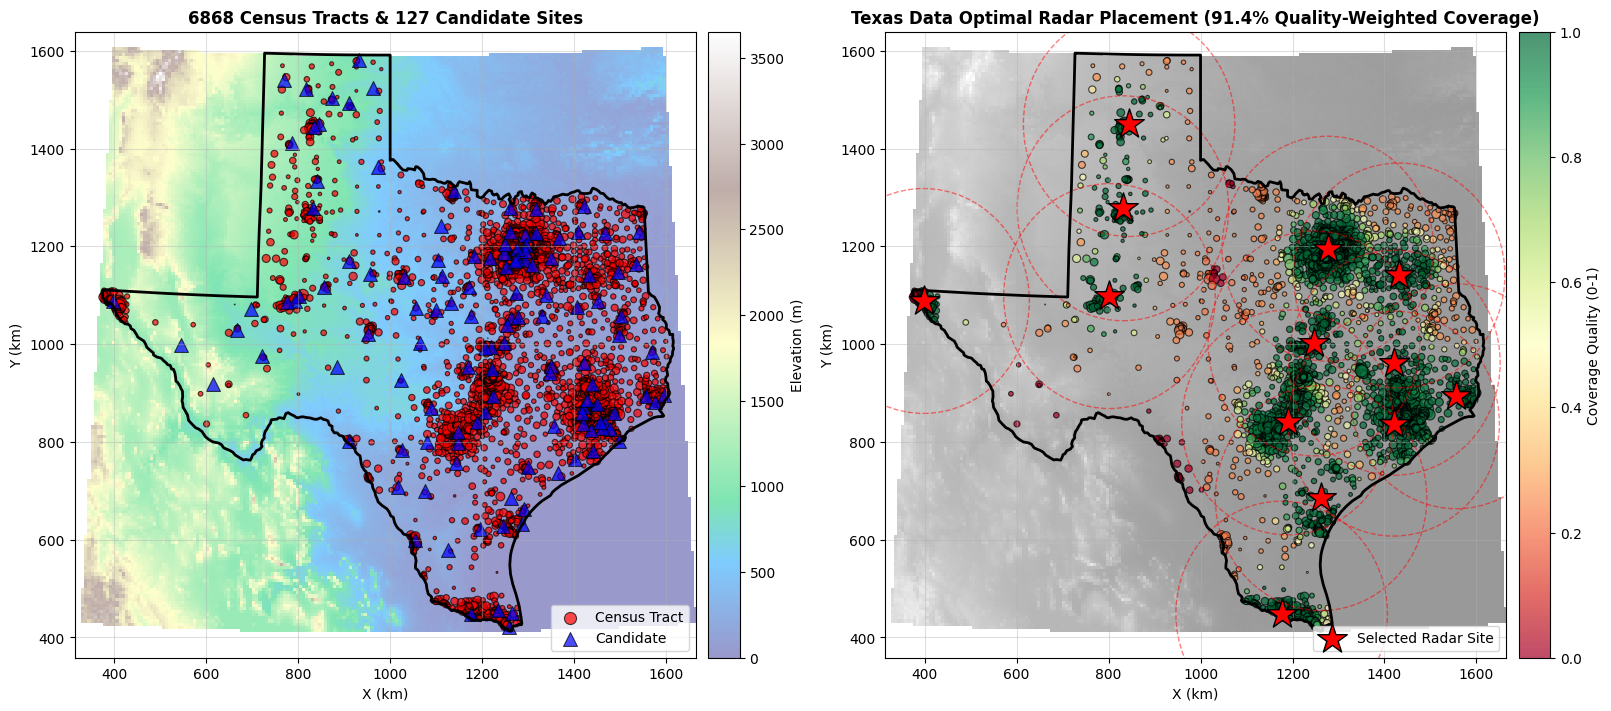

In [15]:
results_texas = display_results(x_tx, z_tx, coverage_df_texas, pop_df_tx, total_population_texas)

# Calculate extent
x_min, x_max = pop_df_tx['x'].min(), pop_df_tx['x'].max()
y_min, y_max = pop_df_tx['y'].min(), pop_df_tx['y'].max()
x_padding = (x_max - x_min) * 0.05
y_padding = (y_max - y_min) * 0.05

# Resample DEM for visualization
print("\nResampling elevation data for visualization...")
x_res, y_res = 200, 200
x_grid = np.linspace(x_min - x_padding, x_max + x_padding, x_res)
y_grid = np.linspace(y_min - y_padding, y_max + y_padding, y_res)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

terrain_display = np.full(X_grid.shape, np.nan)
for i in range(x_res):
    for j in range(y_res):
        lon, lat = transformer.transform(x_grid[i] * 1000, y_grid[j] * 1000)
        try:
            row, col = src.index(lon, lat)
            if 0 <= row < terrain_texas.shape[0] and 0 <= col < terrain_texas.shape[1]:
                val = terrain_texas[row, col]
                terrain_display[j, i] = 0 if val < -1000 else val
        except:
            pass

print(f"Elevation range: {np.nanmin(terrain_display):.0f}m to {np.nanmax(terrain_display):.0f}m")

# Get Texas boundary
usa = gpd.read_file('https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_state_20m.zip')
texas_boundary = usa[usa['NAME'] == 'Texas'].to_crs(epsg=3081)

# Convert to km
texas_boundary_km = texas_boundary.copy()
texas_boundary_km.geometry = texas_boundary_km.geometry.translate(xoff=0, yoff=0).scale(xfact=0.001, yfact=0.001, origin=(0,0))

fig = visualize_results(pop_df_tx, airports_df_tx, results_texas,
                        terrain=terrain_display,
                        extent=[x_min - x_padding, x_max + x_padding,
                                y_min - y_padding, y_max + y_padding],
                        max_range=MAX_RANGE_TEXAS, title_prefix="Texas Data ",
                        km_per_unit=1, boundary=texas_boundary_km)
plt.savefig('radar_location_allocation_texas.png', dpi=150, bbox_inches='tight')
plt.show()

### 5.8 Model Performance on Real-World Data

The final network achieves:
- **Quality-weighted coverage**: 91.44% of population with quality-weighted coverage
- **High-quality coverage**: 89.0% of population with >75% quality score
- **Near-complete coverage**: 98.8% of population with any coverage
- **Efficient resource allocation**: 13 radars serving 29+ million people across 6,787 census tracts

## 6. Conclusion

This project successfully implemented a physics-based Location-Allocation optimization model to design a weather radar network for Texas. By integrating realistic beam propagation physics, terrain blockage data, and population density, the model identified optimal sites that maximize the effective detection of severe weather for the population.

The model successfully identifies optimal placement centered around major population centers (Dallas-Fort Worth, Houston, Rio Grande Valley, etc.) while maintaining broad geographic coverage for rural areas. East Texas contains most of the radars (9 of 13) due to its significantly higher population density, while the 4 radars in west Texas are strategically spread to cover large swaths of the state.

The physics-based approach proved critical to achieving realistic results. The inclusion of Earth curvature and terrain blockage prevented the model from selecting sites that would be theoretically close but physically obstructed. I actually failed to include the Earth's curvature in an earlier iteration of this model, which led to some unrealistic radar placements. Similarly, my distance penalty was originally an exponential decay, but this unrealistically modeled beam widening (which is linear) and led to radar clustering in urban regions. By improving this formulation with more accurate physics, I dramatically improved the model results.

### Key Findings

1. **Urban Prioritization:** The model heavily prioritizes large cities (Dallas, Houston, San Antonio), where population density is highest. This came at the expense of some rural regions, but still avoided redundant radar clustering in single metropolitan areas.

2. **Physics Constraints Matter:** The inclusion of Earth curvature and terrain blockage prevented the model from selecting sites that would be theoretically close but physically obstructed (e.g., by terrain or beam overshooting).

3. **Trade-offs are Inevitable:** With limited resources (13 radars), perfect coverage is impossible. Central Texas remains underserved, highlighting the fundamental resource allocation challenge in facility location problems.

## 7. Future Work and Possible Extensions

### 7.1 Geographic Equity

The most obvious limitation is the underserved central Texas region. Although mostly rural, this could be problematic for observing severe weather events. Future work could:
- Add constraints for land-based coverage, not just population coverage
- Implement county-level minimum coverage thresholds
- Use minimax approaches to minimize worst-case coverage gaps

### 7.2 Enhanced Physics

I spent significant time tweaking the physics models, and each improvement led to visibly better results. Further improvements could include:
- Multiple elevation angles (0.5°, 1.5°, 2.4°, etc.) instead of just 0.5°
- Dual-polarization radar capabilities in quality metrics

### 7.3 Operational Constraints

Real-world deployment involves additional considerations:
- Variable infrastructure costs across different airports
- Maintenance schedules and expected uptime/downtime
- Upgrade versus new build decisions for existing sites